In [27]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [28]:
data_path = Path(r"~/Fahrsimulator_MSY2526_AI/model_training/xgboost/output_windowed.parquet")

In [29]:
df = pd.read_parquet(path=data_path)

In [30]:
subjects = df['subjectID'].unique()
print(subjects)
print(len(subjects))
print(len(subjects)*0.66)
print(len(subjects)*0.33)

[ 0  3  4  5  6  7  9 11 13 14 16 17 18 22 24 26 28 29]
18
11.88
5.94


In [31]:
low_all = df[
    ((df["PHASE"] == "baseline") |
     ((df["STUDY"] == "n-back") & (df["PHASE"] != "baseline") & (df["LEVEL"].isin([1, 4]))))
]
print(f"low all: {low_all.shape}")

high_nback = df[
    (df["STUDY"]=="n-back") &
    (df["LEVEL"].isin([2, 3, 5, 6])) &
    (df["PHASE"].isin(["train", "test"]))
]
print(f"high n-back: {high_nback.shape}")

high_kdrive = df[
    (df["STUDY"] == "k-drive") & (df["PHASE"] != "baseline")
]
print(f"high k-drive: {high_kdrive.shape}")

high_all = pd.concat([high_nback, high_kdrive])
print(f"high all: {high_all.shape}")

low all: (3080, 25)
high n-back: (1031, 25)
high k-drive: (3209, 25)
high all: (4240, 25)


In [32]:
def fit_normalizer(train_data, au_columns, method='standard', scope='global'):
    if method == 'standard':
        Scaler = StandardScaler
    elif method == 'minmax':
        Scaler = MinMaxScaler
    else:
        raise ValueError("method must be 'standard' or 'minmax'")
    
    scalers = {}
    
    if scope == 'subject':
        for subject in train_data['subjectID'].unique():
            subject_mask = train_data['subjectID'] == subject
            scaler = Scaler()
            scaler.fit(train_data.loc[subject_mask, au_columns])
            scalers[subject] = scaler

    elif scope == 'global':
        scaler = Scaler()
        scaler.fit(train_data[au_columns])
        scalers['global'] = scaler

    else:
        raise ValueError("scope must be 'subject' or 'global'")
    
    return {'scalers': scalers, 'method': method, 'scope': scope}


In [33]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

In [35]:
low = low_all.copy()
high = high_all.copy()

low["label"] = 0
high["label"] = 1

data = pd.concat([low, high], ignore_index=True)
data = data.drop_duplicates()

print("Label distribution:")
print(data["label"].value_counts())

Label distribution:
label
1    4240
0    3080
Name: count, dtype: int64


In [36]:
au_columns = [col for col in data.columns if col.lower().startswith("au")]
print("Gefundene AU-Spalten:", au_columns)

Gefundene AU-Spalten: ['AU01_sum', 'AU02_sum', 'AU04_sum', 'AU05_sum', 'AU06_sum', 'AU07_sum', 'AU09_sum', 'AU10_sum', 'AU11_sum', 'AU12_sum', 'AU14_sum', 'AU15_sum', 'AU17_sum', 'AU20_sum', 'AU23_sum', 'AU24_sum', 'AU25_sum', 'AU26_sum', 'AU28_sum', 'AU43_sum']


In [37]:
subjects = np.random.permutation(data["subjectID"].unique())

n = len(subjects)
n_train = int(n * 0.66)

train_subjects = subjects[:n_train]
test_subjects  = subjects[n_train:]
# train_subs, val_subs = train_test_split(train_subjects, test_size=0.2, random_state=42)

train_df = data[data.subjectID.isin(train_subjects)]
#val_df   = data[data.subjectID.isin(val_subs)]
test_df  = data[data.subjectID.isin(test_subjects)]

print(train_df.shape, test_df.shape)
print(train_subjects)
print(train_df.columns)

(4470, 26) (2850, 26)
[18  4  9 22  5  3 13 11 24  0 14]
Index(['subjectID', 'start_time', 'STUDY', 'LEVEL', 'PHASE', 'AU01_sum',
       'AU02_sum', 'AU04_sum', 'AU05_sum', 'AU06_sum', 'AU07_sum', 'AU09_sum',
       'AU10_sum', 'AU11_sum', 'AU12_sum', 'AU14_sum', 'AU15_sum', 'AU17_sum',
       'AU20_sum', 'AU23_sum', 'AU24_sum', 'AU25_sum', 'AU26_sum', 'AU28_sum',
       'AU43_sum', 'label'],
      dtype='object')


In [38]:
def apply_normalizer(df_to_transform, normalizer_dict, au_columns):
    scalers = normalizer_dict["scalers"]
    scope = normalizer_dict["scope"]
    df_out = df_to_transform.copy()

    if scope == "global":
        scaler = scalers["global"]
        df_out[au_columns] = scaler.transform(df_out[au_columns])

    elif scope == "subject":
        for subj, subdf in df_out.groupby("subjectID"):
            if subj in scalers:
                df_out.loc[subdf.index, au_columns] = scalers[subj].transform(subdf[au_columns])
            elif "global" in scalers:
                df_out.loc[subdf.index, au_columns] = scalers["global"].transform(subdf[au_columns])

    return df_out

In [39]:
normalizer = fit_normalizer(train_df, au_columns, method="standard", scope="global")

train_scaled = apply_normalizer(train_df, normalizer, au_columns)
#val_scaled   = apply_normalizer(val_df, normalizer, au_columns)
test_scaled  = apply_normalizer(test_df, normalizer, au_columns)

print(test_scaled.columns)

Index(['subjectID', 'start_time', 'STUDY', 'LEVEL', 'PHASE', 'AU01_sum',
       'AU02_sum', 'AU04_sum', 'AU05_sum', 'AU06_sum', 'AU07_sum', 'AU09_sum',
       'AU10_sum', 'AU11_sum', 'AU12_sum', 'AU14_sum', 'AU15_sum', 'AU17_sum',
       'AU20_sum', 'AU23_sum', 'AU24_sum', 'AU25_sum', 'AU26_sum', 'AU28_sum',
       'AU43_sum', 'label'],
      dtype='object')


In [40]:
# Neue Feature-Liste: AU-Spalten + subjectID
feature_columns = au_columns + ["subjectID"]

# X und y erstellen
X_train = train_scaled[feature_columns].values
y_train = train_scaled["label"].values

#X_val,   y_val   = val_scaled[au_columns].values, val_scaled["label"].values
X_test,  y_test  = test_scaled[au_columns].values, test_scaled["label"].values

In [41]:
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)

# Parameter-Raster
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "n_estimators": [200, 500, 800],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# GroupKFold (keine shuffle/random_state Parameter!)
cv = GroupKFold(n_splits=5)

# Grid Search Setup
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=2
)

# Training mit Cross Validation, Gruppen übergeben
X_train = train_scaled[au_columns].values
y_train = train_scaled["label"].values
groups  = train_scaled["subjectID"].values

grid_search.fit(X_train, y_train, groups=groups)


print("Beste Parameter:", grid_search.best_params_)
print("Bestes AUC:", grid_search.best_score_)

# Bestes Modell extrahieren
model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:10] WARNING: /w

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estima

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:46] WARNING: /w

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estima

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:19:48] WARNING: /w


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estim

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Beste Parameter: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Bestes AUC: 0.7129603264527704


/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TRAIN:
VAL:
TEST:
Accuracy: 0.6803508771929825
F1: 0.7677797603874585
AUC: 0.6365290011197031
Confusion:
 [[ 433  765]
 [ 146 1506]]
              precision    recall  f1-score   support

           0       0.75      0.36      0.49      1198
           1       0.66      0.91      0.77      1652

    accuracy                           0.68      2850
   macro avg       0.71      0.64      0.63      2850
weighted avg       0.70      0.68      0.65      2850



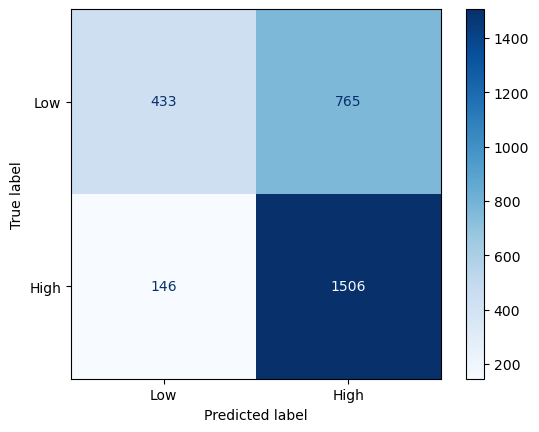

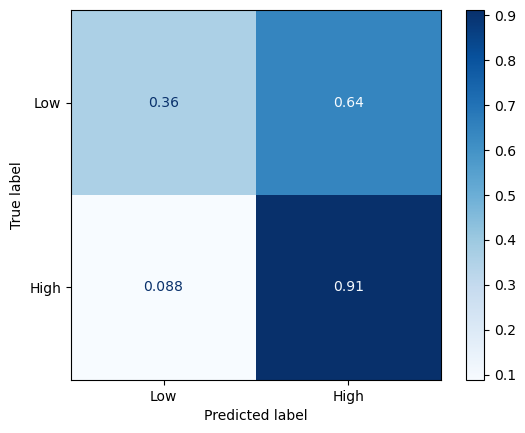

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

def evaluate(model, X, y, title="Evaluation"):
    # Vorhersagen
    preds_proba = model.predict_proba(X)[:, 1]
    preds = (preds_proba > 0.5).astype(int)

    # Metriken ausgeben
    print("Accuracy:", accuracy_score(y, preds))
    print("F1:", f1_score(y, preds))
    print("AUC:", roc_auc_score(y, preds))
    print("Confusion:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds))

    # Confusion Matrix plotten
    def plot_confusion_matrix(true_labels, predictions, label_names):
        for normalize in [None, 'true']:
            cm = confusion_matrix(true_labels, predictions, normalize=normalize)
            cm_disp = ConfusionMatrixDisplay(cm,  display_labels=label_names)
            cm_disp.plot(cmap="Blues")
    plot_confusion_matrix(y,preds, label_names=['Low','High'])


# Aufrufen für Train/Val/Test
print("TRAIN:")
#evaluate(model, X_train[au_columns].values, y_train, title="Train")

print("VAL:")
#evaluate(model, X_val, y_val, title="Validation")

print("TEST:")
evaluate(model, X_test, y_test, title="Test")


In [ ]:
joblib.dump(model, "xgb_model_3_groupK.joblib")
joblib.dump(normalizer, "normalizer_3_groupK.joblib")
print("Model gespeichert.")

#model.save_model("xgb_model.json")   # als JSON (lesbar, portabel)
#model.save_model("xgb_model.bin")    # als Binärdatei (kompakt)

Model gespeichert.



[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estim

Exception ignored in: <function ResourceTracker.__del__ at 0x7f2b26cb3d80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=800, subsample=1.0; total time=   0.7s


Exception ignored in: <function ResourceTracker.__del__ at 0x7ff884f4bd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estim

Exception ignored in: <function ResourceTracker.__del__ at 0x7f89d9447d80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=800, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estim

Exception ignored in: <function ResourceTracker.__del__ at 0x7f52cb243d80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/conda/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
